## Bachelor Arbeit:

Wie stark sind die Auswirkungen von Transfer Learning bezüglich der Effizienz und Effektivität künstlicher neuronaler Netze anhand des Beispiels Autokennzeichen-Erkennung, wenn die erhebbaren Daten begrenzt sind?
***
How strong is the impact of transfer learning regarding the efficiency and effectiveness of convolutional neural networks, based on the example of detecting vehicle registration plates, assuming working with limited datasets?

#### Requirements
Es kann beim Installieren der Packages zu Kompatibilitätsproblemen kommen. Model Maker benötigt einerseits eine setuptools Version <= 58 (https://stackoverflow.com/questions/69100275/error-while-downloading-the-requirements-using-pip-install-setup-command-use-2) und andererseits unterstützt Model Maker keine Tensorflow Version über 2.9. Sollte eine aktuellere Tensorflow Version installiert sein, muss diese zuerst samt protobuf deinstalliert werden - https://stackoverflow.com/questions/42006320/tensorflow-pip-installation-issue-cannot-import-name-descriptor. Error: pip cannot uninstall 'package': "It is a distutils installed project" kann mittels manuellem Deinstallieren des packages umgangen werden (https://stackoverflow.com/questions/53807511/pip-cannot-uninstall-package-it-is-a-distutils-installed-project).

In [1]:
# install required packages
!pip install --upgrade pip setuptools==58
!pip install fiftyone
!pip install tflite-model-maker

     ---------------------------------------- 2.1/2.1 MB 4.0 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\Benni\.conda\envs\bachelor_thesis\python.exe -m pip install --upgrade pip setuptools==58


In [9]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from tflite_model_maker import config
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier

from util import load_fiftyone_dataset, plot_model_history

### Data preprocessing

#### Download data
Zuerst werden in den folgenden Codezeilen Trainings-, Test- und Validationsdaten von der Open Images Datenbank (https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection&set=train&c=%2Fm%2F01jfm_) heruntergeladen. Dazu wird die von Google empfohlene FiftyOne Bibliothek verwendet (https://voxel51.com/docs/fiftyone/, https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#open-images-v6). Als Trainingsgrundlage werden 500 Bilder mit Autokennzeichen inklusive Ground-Truth Daten und 500 Bilder mit Hunden, Katzen und Äpfel (für die negativen Labels)  geladen. Die Validationsdaten und Testdaten bestehen aus jeweils 100 Bildern.

Die genaue Implementierung ist in util.py zu finden.

INFO:fiftyone.zoo.datasets:Downloading split 'train' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train\metadata\image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [1.2m elapsed, 0s remaining, 67.2Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [1.2m elapsed, 0s remaining, 67.2Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train\metadata\classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to 'C:\Users\Benni\AppData\Local\Temp\tmpzysqwcje\metadata\hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-human-imagelabels-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train\labels\classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 500 images


 100% |███████████████████| 500/500 [32.2s elapsed, 0s remaining, 23.0 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 500/500 [32.2s elapsed, 0s remaining, 23.0 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 500/500 [461.5ms elapsed, 0s remaining, 1.1K samples/s]       


INFO:eta.core.utils: 100% |█████████████████| 500/500 [461.5ms elapsed, 0s remaining, 1.1K samples/s]       


Dataset 'open-images-v6-train' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-train' created


INFO:fiftyone.zoo.datasets:Downloading split 'train' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train' if necessary


Found 14 images, downloading the remaining 486


INFO:fiftyone.utils.openimages:Found 14 images, downloading the remaining 486


 100% |███████████████████| 486/486 [30.0s elapsed, 0s remaining, 19.4 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 486/486 [30.0s elapsed, 0s remaining, 19.4 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 500/500 [490.3ms elapsed, 0s remaining, 1.0K samples/s]       


INFO:eta.core.utils: 100% |█████████████████| 500/500 [490.3ms elapsed, 0s remaining, 1.0K samples/s]       


Dataset 'dataset_2' created


INFO:fiftyone.zoo.datasets:Dataset 'dataset_2' created


 100% |█████████████████| 500/500 [578.7ms elapsed, 0s remaining, 863.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [578.7ms elapsed, 0s remaining, 863.9 samples/s]      


INFO:fiftyone.zoo.datasets:Downloading split 'test' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\test' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\test\metadata\image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\test\metadata\classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to 'C:\Users\Benni\AppData\Local\Temp\tmpe8r0qjas\metadata\hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-annotations-human-imagelabels-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\test\labels\classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 50 images


 100% |█████████████████████| 50/50 [4.9s elapsed, 0s remaining, 10.6 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 50/50 [4.9s elapsed, 0s remaining, 10.6 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'test'


 100% |███████████████████| 50/50 [83.8ms elapsed, 0s remaining, 596.6 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 50/50 [83.8ms elapsed, 0s remaining, 596.6 samples/s]  


Dataset 'open-images-v6-test' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-test' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\test' if necessary


INFO:fiftyone.utils.openimages:Downloading 50 images


 100% |█████████████████████| 50/50 [4.0s elapsed, 0s remaining, 19.0 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 50/50 [4.0s elapsed, 0s remaining, 19.0 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'test'


 100% |███████████████████| 50/50 [73.0ms elapsed, 0s remaining, 685.1 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 50/50 [73.0ms elapsed, 0s remaining, 685.1 samples/s]  


Dataset 'dataset_2' created


INFO:fiftyone.zoo.datasets:Dataset 'dataset_2' created


 100% |███████████████████| 50/50 [60.3ms elapsed, 0s remaining, 829.2 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 50/50 [60.3ms elapsed, 0s remaining, 829.2 samples/s]     


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\validation\metadata\image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\validation\metadata\classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to 'C:\Users\Benni\AppData\Local\Temp\tmp14y0tr8s\metadata\hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels-boxable.csv' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\validation\labels\classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 50 images


 100% |█████████████████████| 50/50 [3.8s elapsed, 0s remaining, 19.7 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 50/50 [3.8s elapsed, 0s remaining, 19.7 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |███████████████████| 50/50 [71.4ms elapsed, 0s remaining, 700.6 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 50/50 [71.4ms elapsed, 0s remaining, 700.6 samples/s]  


Dataset 'open-images-v6-validation' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation' created


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 50 images


 100% |█████████████████████| 50/50 [4.0s elapsed, 0s remaining, 19.7 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 50/50 [4.0s elapsed, 0s remaining, 19.7 files/s]      


Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |███████████████████| 50/50 [71.7ms elapsed, 0s remaining, 696.9 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 50/50 [71.7ms elapsed, 0s remaining, 696.9 samples/s]  


Dataset 'dataset_2' created


INFO:fiftyone.zoo.datasets:Dataset 'dataset_2' created


 100% |███████████████████| 50/50 [61.3ms elapsed, 0s remaining, 815.6 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 50/50 [61.3ms elapsed, 0s remaining, 815.6 samples/s]     


-----------------------------------------------------
1000
100
100
Filepath:  C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train\data\0000048549557964.jpg


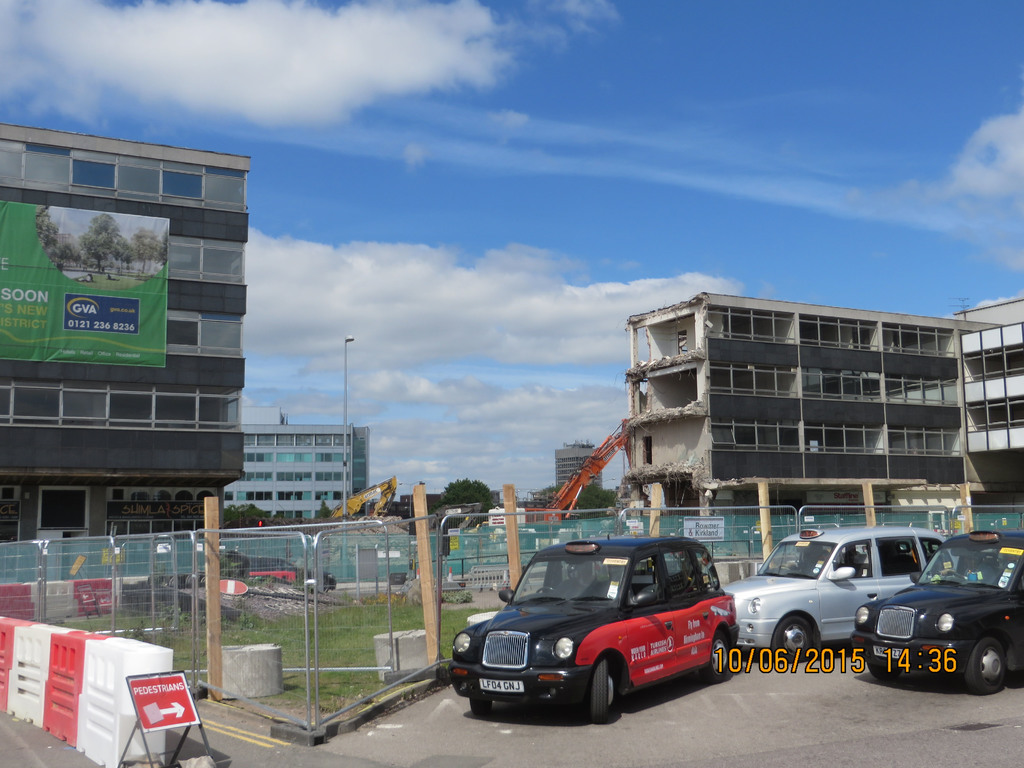

In [10]:
# download data from Open Image Dataset V6
train_dataset = load_fiftyone_dataset("train")
test_dataset = load_fiftyone_dataset("test")
val_dataset = load_fiftyone_dataset("validation")

print("-----------------------------------------------------")
print(train_dataset.count())
print(test_dataset.count())
print(val_dataset.count())
print("Filepath: ", train_dataset.first().filepath)
array_to_img(load_img(train_dataset.first().filepath))

#### Data conversion

Um die Daten in das CNN von Googles TensorFlow Lite Model Maker Bibliothek und in das selbst implementierte neuronale Netz füttern zu können, müssen sie zuerst angepasst werden:

Als erstes werden die Datensätze (Bilder und Labels) in numpy arrays geladen.

Wie in der API Dokumentation der TensorFlow Lite Model Maker Bibliothek festgehalten wird (https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier), benützt Model Maker per default ein vortrainiertes EfficientNet-Lite0 Model. Dieses Model ist ein für mobile Geräte optimiertes neuronales Netzwerk, ideal für Edge Computing, und spiegelt den Anwendungsfall dieser Arbeit somit sehr gut wider. In weiterer Folge wird jedoch nicht EfficientNet-Lite0 sondern die Weiterentwicklung EfficientNet-Lite4 verwendet. Dieses Netz ist zwar etwas langsamer als sein Vorgänger, erreicht dafür jedoch höhere Trefferquoten. Zudem ist das CNN ebenfalls für mobile Anwendungen optimiert und der Geschwindigkeitsverlust ist verkraftbar. Genaueres kann in der Dokumentation nachgelesen werden: https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite?utm_source=www.tensorflow.org&utm_medium=referral.
EfficientNet-Lite4 unterstützt Eingabebilder des Formates (224, 224, 3) und Bildwerte im Bereich -1 bis 1. Um möglichst repräsentative Vergleichswerte für die 2 Models zu erhalten, müssen die Daten des neu aufgesetzen neuronalen Netzes an die Vorgaben des durch Model Maker trainierten CNNs angepasst werden. Folglich werden die Bilder der Datensätze an dieses Format angepasst und die Bildwerte von einem 0-255 Zahlenraum in Gleitkommazahlen zwischen 0-1 skaliert.

Die Model Maker Bibliothek erwartet Daten im Format der internen DataLoader Klasse (https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/DataLoader). Nachdem diese Schnittstelle keine numpy Arrays unterstützt, wurde eine Methode zur Konvertierung der Arrays in das gewünschte Format implementiert. Dazu wurden Codepassagen aus der DataLoader GitHub Repository genommen: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/core/data_util/image_dataloader.py?utm_source=www.tensorflow.org&utm_medium=referral#L53-L106.

In [11]:
IMG_DIM = (224, 224)

def load_datasetView_into_npArrays(datasetView):
    
    # load images of a fiftyone dataset view into a np.array
    samples = np.array([img_to_array(load_img(img.filepath, target_size=IMG_DIM)) for img in datasetView])
    samples = samples.astype('float32')
    samples /= 255
    
    # load labels of a fiftyone dataset view into a np.array
    labels = np.array([
        any(classification['label'] == 'Vehicle registration plate'
            for classification in sample['positive_labels']['classifications'])
        for sample in datasetView])
    
    return samples, labels.astype(int)

### TensorFlow conversions
#TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#attributes_1
#numpy as TFDataset:
#https://www.tensorflow.org/guide/data#reading_input_data
#https://www.tensorflow.org/tutorials/load_data/numpy
def load_imageTensor(path):
    image_raw = tf.io.read_file(path)
    image_tensor = tf.cond(
      tf.image.is_jpeg(image_raw),
      lambda: tf.image.decode_jpeg(image_raw, channels=3),
      lambda: tf.image.decode_png(image_raw, channels=3))
    return image_tensor

def get_data_in_DataLoader_format(datasetView, labels, training=False):
    #get all filepaths
    all_image_paths = []
    for image in datasetView:
        all_image_paths.append(image.filepath)
        
    #set label names = index to labels (0 = Others, 1 = Vehicle registration plate)
    label_names = ['Others', 'Vehicle registration plate']
    
    #load tensorflow datasets
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = path_ds.map(load_imageTensor)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))  
    return tf.data.Dataset.zip((image_ds, label_ds)).shuffle(1000), len(all_image_paths), label_names

First 10 labels of y_train:  [1 0 1 0 0 0 0 1 1 0]
X_train[0].shape:  (224, 224, 3)


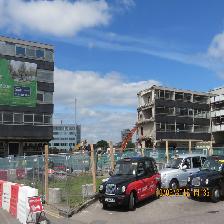

In [12]:
# load images and labels/ground_truth into numpy arrays
X_train, y_train = load_datasetView_into_npArrays(train_dataset)
X_val, y_val = load_datasetView_into_npArrays(val_dataset)
X_test, y_test = load_datasetView_into_npArrays(test_dataset)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print("First 10 labels of y_train: ", y_train[:10])
print("X_train[0].shape: ", X_train[0].shape)
array_to_img(X_train[0])

In [13]:
# load parameters for image_classifier.DataLoader conversion
train_ds, train_ds_size, train_names = get_data_in_DataLoader_format(train_dataset, y_train)

val_ds, val_ds_size, val_names = get_data_in_DataLoader_format(val_dataset, y_val)
tl_val_data = image_classifier.DataLoader(val_ds, val_ds_size, val_names)

test_ds, test_ds_size, test_names = get_data_in_DataLoader_format(test_dataset, y_test)
tl_test_data = image_classifier.DataLoader(test_ds, test_ds_size, test_names)

#### Data augmentation

Die TensorFlow Lite Model Maker Bibliothek bietet die Option eines integrierten "image augmentation" Algorithmuses. Dieser Schritt ist eine übliche Vorgehensweise, wenn die Daten begrenzt sind. Bilderweiterung erlaubt es durch Diversifizierung (Abändern der Bildparameter wie die Drehung des Bildes, das Format,...) ein Model mit mehreren unterschiedlichen Samples zu füttern und somit das Risiko von Overfitting zu minimieren. Durch das Setzen des use_augmentation Flags wird der Algorithmus aktiviert.
Um die Daten möglichst vergleichbar zu halten, wurde jedoch ein eigener Algorithmus implementiert.

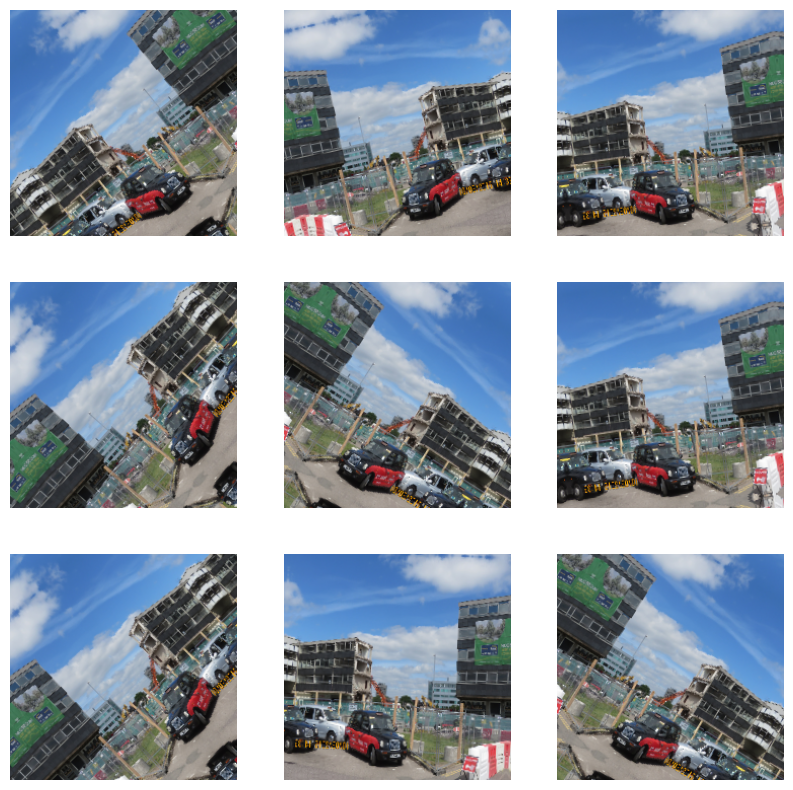

In [14]:
#https://www.tensorflow.org/tutorials/images/data_augmentation
#https://www.tensorflow.org/api_docs/python/tf/keras/layers
#https://keras.io/guides/preprocessing_layers/
#https://www.tensorflow.org/tutorials/images/classification#create_a_dataset
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.15),
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X_train[:1])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
    
def augment_data(tf_ds):
    return tf_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# number of images passed to the CNN in one iteration (weights are updated after one iteration)
batch_size = 30

#augment trainingsdatasets
tl_train_data = image_classifier.DataLoader(augment_data(train_ds), train_ds_size, train_names)
train_data = augment_data(tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size))

### Convolutional Neural Networks

#### Transfer Learning ("EfficientNet-Lite4" model)

In folgendem Codeabschnitt werden die "batch_size" und die "epochs" gesetzt. Die batch size definiert wie viele Bilder an das neuronale Netz pro Wiederholung übergeben werden. Dabei beschreibt eine Wiederholung das Zeitintervall für die Anpassung der Gewichte eines neuronalen Netzes. Eine Epoche beschreibt die Anzahl der Wiederholungen des gesamten Datensatzes.

Beispiel:
Eine batch size von 10 gibt an, dass nach 10 Bildern die Gewichte angepasst werden. Der Trainingsdatensatz beinhaltet 320 Bilder. Eine sogenannte Epoche beinhaltet also 32 Wiederholungen/Batches, sprich 32 Gewichtsanpassungen. Ein "epochs" Wert von 30 bedeutet somit insgesamt 32x30 Batches/Gewichtsanpassungen.

In [15]:
# number of iterations over the whole dataset (high number will most likely result in overfitting)
epochs = 30

In [16]:
# retrain model with hyperparameters
#https://www.tensorflow.org/lite/models/modify/model_maker/image_classification#change_the_training_hyperparameters
#https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/ImageClassifier
tflite_model = image_classifier.create(
    tl_train_data,
    validation_data=tl_val_data,
    model_spec=model_spec.get('efficientnet_lite4'),
    train_whole_model=False,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    use_augmentation=False
)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             11837936  
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 11,840,498
Trainable params: 2,562
Non-trainable params: 11,837,936
_________________________________________________________________
None
Epoch 1/30


C:\Users\Benni\.conda\envs\bachelor_thesis\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


33/33 [==============================] - 61s 2s/step - loss: 0.5182 - accuracy: 0.7818 - val_loss: 0.4023 - val_accuracy: 0.8200
Epoch 2/30
33/33 [==============================] - 59s 2s/step - loss: 0.3954 - accuracy: 0.8707 - val_loss: 0.4025 - val_accuracy: 0.8600
Epoch 3/30
33/33 [==============================] - 59s 2s/step - loss: 0.3793 - accuracy: 0.8838 - val_loss: 0.3891 - val_accuracy: 0.8400
Epoch 4/30
33/33 [==============================] - 59s 2s/step - loss: 0.3773 - accuracy: 0.8828 - val_loss: 0.3791 - val_accuracy: 0.8800
Epoch 5/30
33/33 [==============================] - 60s 2s/step - loss: 0.3666 - accuracy: 0.9030 - val_loss: 0.3812 - val_accuracy: 0.8700
Epoch 6/30
33/33 [==============================] - 60s 2s/step - loss: 0.3528 - accuracy: 0.9010 - val_loss: 0.3783 - val_accuracy: 0.8700
Epoch 7/30
33/33 [==============================] - 59s 2s/step - loss: 0.3506 - accuracy: 0.9091 - val_loss: 0.3692 - val_accuracy: 0.8900
Epoch 8/30
33/33 [=============

In [17]:
# evaluate not quantized model
print(tflite_model.evaluate(tl_test_data))

4/4 [==============================] - 5s 1s/step - loss: 0.3824 - accuracy: 0.8800
[0.38237449526786804, 0.8799999952316284]


In [18]:
# export tflite model
tflite_model.export(export_dir='./models',
                    export_format=config.ExportFormat.TFLITE,
                    tflite_filename='tl_model.tflite')

INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpyecuwn1a\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpyecuwn1a\assets
C:\Users\Benni\.conda\envs\bachelor_thesis\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmpt_fotlui\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmpt_fotlui\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model.tflite


In [25]:
epochs = 10

# advanced transfer learning model
tflite_model_adv = image_classifier.create(
    tl_train_data,
    validation_data=tl_val_data,
    model_spec=model_spec.get('efficientnet_lite4'),
    train_whole_model=True,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    use_augmentation=False
)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_4 (Hub  (None, 1280)             11837936  
 KerasLayerV1V2)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 11,840,498
Trainable params: 11,840,498
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


33/33 [==============================] - 276s 8s/step - loss: 0.4815 - accuracy: 0.8192 - val_loss: 0.3964 - val_accuracy: 0.9100
Epoch 2/10
33/33 [==============================] - 262s 8s/step - loss: 0.4050 - accuracy: 0.8737 - val_loss: 0.3320 - val_accuracy: 0.9200
Epoch 3/10
33/33 [==============================] - 262s 8s/step - loss: 0.3574 - accuracy: 0.9040 - val_loss: 0.3280 - val_accuracy: 0.9200
Epoch 4/10
33/33 [==============================] - 274s 8s/step - loss: 0.3263 - accuracy: 0.9202 - val_loss: 0.3318 - val_accuracy: 0.9000
Epoch 5/10
33/33 [==============================] - 277s 8s/step - loss: 0.3109 - accuracy: 0.9444 - val_loss: 0.3268 - val_accuracy: 0.9200
Epoch 6/10
33/33 [==============================] - 273s 8s/step - loss: 0.3178 - accuracy: 0.9182 - val_loss: 0.3262 - val_accuracy: 0.9300
Epoch 7/10
33/33 [==============================] - 267s 8s/step - loss: 0.2980 - accuracy: 0.9313 - val_loss: 0.3072 - val_accuracy: 0.9300
Epoch 8/10
33/33 [======

In [26]:
# evaluate not quantized model
print(tflite_model_adv.evaluate(tl_test_data))

4/4 [==============================] - 6s 1s/step - loss: 0.3779 - accuracy: 0.9200
[0.3779243230819702, 0.9200000166893005]


In [27]:
# post training quantization
from tflite_model_maker.config import QuantizationConfig
# quantization papers: https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4
# general overview: https://www.tensorflow.org/lite/performance/post_training_quantization
#https://blog.tensorflow.org/2020/03/higher-accuracy-on-vision-models-with-efficientnet-lite.html
#https://www.tensorflow.org/lite/performance/model_optimization
#https://blog.tensorflow.org/2019/06/tensorflow-integer-quantization.html?_gl=1*bcrpzk*_ga*MTA3MjAxMzg3Mi4xNjU4ODQ1Mzk0*_ga_W0YLR4190T*MTY3NDM3NjcyNi4zMy4xLjE2NzQzNzcwMDQuMC4wLjA.
#Model Maker build in quantization:https://www.tensorflow.org/lite/models/modify/model_maker/image_classification#customize_post-training_quantization_on_the_tensorflow_lite_model
#https://www.tensorflow.org/lite/models/convert/
#https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization
#https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig
#https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite?utm_source=www.tensorflow.org&utm_medium=referral

# 8 Bit Integer Quantisierung (CPU, Edge TPU, Microcontrollers)
quantization_config = QuantizationConfig.for_int8(representative_data=tl_test_data)
tflite_model_adv.export(export_dir='./models', export_format=config.ExportFormat.TFLITE, tflite_filename='tl_model_8int.tflite', quantization_config=quantization_config)

# 16 Bit Float Quantisierung (CPU, GPU)
quantization_config = QuantizationConfig.for_float16()
tflite_model_adv.export(export_dir='./models', export_format=config.ExportFormat.TFLITE, tflite_filename='tl_model_16f.tflite', quantization_config=quantization_config)

# 32 Bit Float Quantisierung (CPU, GPU)
tflite_model_adv.export(export_dir='./models',export_format=config.ExportFormat.TFLITE, tflite_filename='tl_model_32f.tflite', quantization_config=None)

INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp2sap44h3\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp2sap44h3\assets
C:\Users\Benni\.conda\envs\bachelor_thesis\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmpm4fjxcix\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmpm4fjxcix\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_8int.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_8int.tflite


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpkjuep5cv\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpkjuep5cv\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmp3rgk8j6l\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmp3rgk8j6l\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_16f.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_16f.tflite


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp2ivjfk9o\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp2ivjfk9o\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmp3j3umivy\labels.txt


INFO:tensorflow:Saving labels in C:\Users\Benni\AppData\Local\Temp\tmp3j3umivy\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_32f.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\tl_model_32f.tflite


In [28]:
tflite_model_adv.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_4 (Hub  (None, 1280)             11837936  
 KerasLayerV1V2)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 11,840,498
Trainable params: 11,840,498
Non-trainable params: 0
_________________________________________________________________


#### Training CNN from scratch

##### References:

Keras Layer API:\
https://keras.io/api/layers/

loss calculation:\
https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

In [29]:
#initial model
#https://keras.io/api/models/model_training_apis/
#https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-2
#https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
#https://towardsdatascience.com/all-machine-learning-models-explained-in-6-minutes-9fe30ff6776a

epochs = 50
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'])

history = model.fit(
    x=train_data,
    validation_data=val_data.batch(batch_size),
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/50
34/34 [==============================] - 22s 618ms/step - loss: 0.8580 - accuracy: 0.6830 - val_loss: 0.7393 - val_accuracy: 0.6400
Epoch 2/50
34/34 [==============================] - 21s 614ms/step - loss: 0.6280 - accuracy: 0.6920 - val_loss: 0.5445 - val_accuracy: 0.6700
Epoch 3/50
34/34 [==============================] - 21s 620ms/step - loss: 0.5857 - accuracy: 0.6920 - val_loss: 0.6261 - val_accuracy: 0.6500
Epoch 4/50
34/34 [==============================] - 21s 617ms/step - loss: 0.5713 - accuracy: 0.7260 - val_loss: 0.4730 - val_accuracy: 0.8100
Epoch 5/50
34/34 [==============================] - 21s 615ms/step - loss: 0.5696 - accuracy: 0.7270 - val_loss: 0.5924 - val_accuracy: 0.7300
Epoch 6/50
34/34 [==============================] - 21s 613ms/step - loss: 0.5359 - accuracy: 0.7360 - val_loss: 0.5069 - val_accuracy: 0.7800
Epoch 7/50
34/34 [==============================] - 21s 615ms/step - loss: 0.5357 - accuracy: 0.7440 - val_loss: 0.4532 - val_accuracy: 0.8200

In [30]:
model.summary()
model.save('./models/model.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

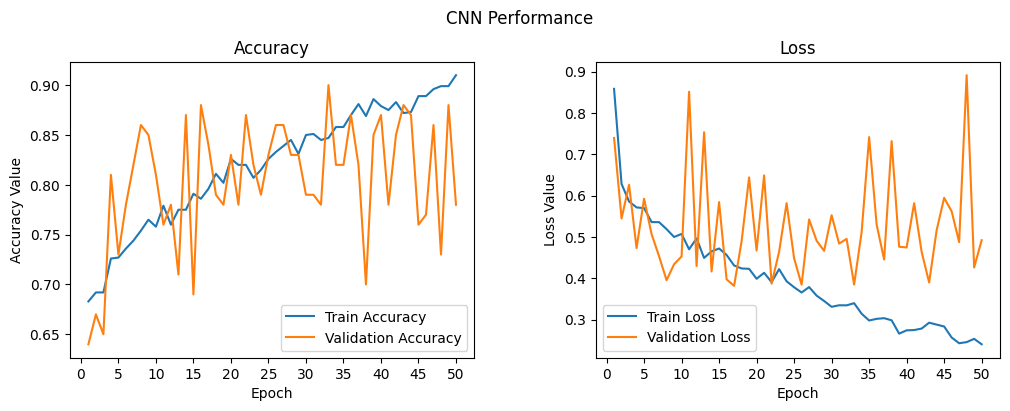

In [31]:
plot_model_history(history, epochs)

In [39]:
#advanced model
#https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
epochs = 37

model_adv = Sequential()

model_adv.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model_adv.add(MaxPooling2D(pool_size=(2, 2)))

model_adv.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_adv.add(MaxPooling2D(pool_size=(2, 2)))

model_adv.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_adv.add(MaxPooling2D(pool_size=(2, 2)))

model_adv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_adv.add(MaxPooling2D(pool_size=(2, 2)))

model_adv.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model_adv.add(MaxPooling2D(pool_size=(2, 2)))

model_adv.add(Flatten())
model_adv.add(Dense(512, activation='relu'))

model_adv.add(Dropout(0.3))
model_adv.add(Dense(1, activation='sigmoid'))

model_adv.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'])

history_adv = model_adv.fit(
    x=train_data,
    validation_data=val_data.batch(batch_size),
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/37
34/34 [==============================] - 20s 559ms/step - loss: 0.7195 - accuracy: 0.6670 - val_loss: 0.6459 - val_accuracy: 0.6400
Epoch 2/37
34/34 [==============================] - 19s 549ms/step - loss: 0.6216 - accuracy: 0.6860 - val_loss: 0.6929 - val_accuracy: 0.4300
Epoch 3/37
34/34 [==============================] - 18s 538ms/step - loss: 0.6183 - accuracy: 0.6920 - val_loss: 0.6663 - val_accuracy: 0.6400
Epoch 4/37
34/34 [==============================] - 18s 537ms/step - loss: 0.5951 - accuracy: 0.7070 - val_loss: 0.5886 - val_accuracy: 0.6400
Epoch 5/37
34/34 [==============================] - 19s 539ms/step - loss: 0.5505 - accuracy: 0.7480 - val_loss: 0.6439 - val_accuracy: 0.7100
Epoch 6/37
34/34 [==============================] - 18s 538ms/step - loss: 0.5720 - accuracy: 0.7270 - val_loss: 0.4779 - val_accuracy: 0.8000
Epoch 7/37
34/34 [==============================] - 19s 562ms/step - loss: 0.5235 - accuracy: 0.7280 - val_loss: 0.5066 - val_accuracy: 0.8200

In [40]:
model_adv.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 64)     

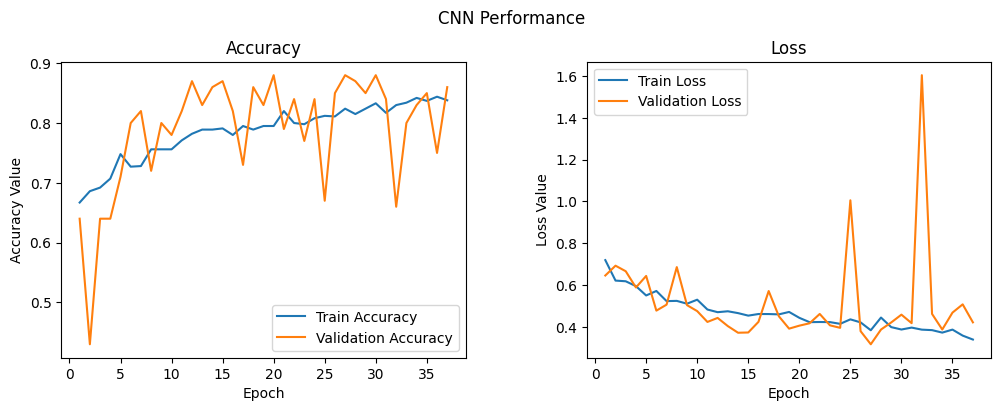

In [41]:
plot_model_history(history_adv, epochs)

In [42]:
model_adv.save('./models/model_adv.h5')

In [43]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]
        
def save_tflite_model(tflite_model, filename):
    with open(filename, 'wb') as f:
        f.write(tflite_model)

In [44]:
#https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4
#https://www.tensorflow.org/lite/performance/post_training_quantization
#https://www.tensorflow.org/lite/models/convert/convert_models
#https://www.tensorflow.org/model_optimization/guide/quantization/post_training
#https://www.tensorflow.org/lite/performance/post_training_integer_quant
#https://www.tensorflow.org/lite/api_docs/python/tf/lite/TFLiteConverter

# 8 Bit Integer Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quant_model_8 = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_adv)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quant_model_adv_8 = converter.convert()

save_tflite_model(quant_model_8, './models/model_8int.tflite')
save_tflite_model(quant_model_adv_8, './models/model_adv_8int.tflite')

# 16 Bit Float Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quant_model_16 = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_adv)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quant_model_adv_16 = converter.convert()

save_tflite_model(quant_model_16, './models/model_16f.tflite')
save_tflite_model(quant_model_adv_16, './models/model_adv_16f.tflite')

# 32 Bit Float Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
quant_model_32 = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_adv)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
quant_model_adv_32 = converter.convert()

save_tflite_model(quant_model_32, './models/model_32f.tflite')
save_tflite_model(quant_model_adv_32, './models/model_adv_32f.tflite')

INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp_4tju5_5\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmp_4tju5_5\assets
C:\Users\Benni\.conda\envs\bachelor_thesis\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpvzz6my78\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpvzz6my78\assets
C:\Users\Benni\.conda\envs\bachelor_thesis\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpwlvngm4h\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpwlvngm4h\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpcdsu2pex\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpcdsu2pex\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpa5brl7x5\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpa5brl7x5\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpxbujvyso\assets


INFO:tensorflow:Assets written to: C:\Users\Benni\AppData\Local\Temp\tmpxbujvyso\assets
